In [11]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os
import RGBHSL

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
def mass_hsl_rgb(my_list):
    new_list = np.zeros(my_list.shape)
    for i in range(len(my_list)):
        new_list[i] = RGBHSL.image_coverter(np.clip(my_list[i],0,1), RGBHSL.pixel_hsl_to_rgb, normalized_input=True, normalize_output=True)
    return new_list

In [78]:
#locloc = "BigDataCubes\CombinedDatasets" 
#namename = "\Part0"
locloc = "BigData\\" 
namename = "TestBigPastel"
all_photos = np.load(locloc + namename + 'Photos.npy')
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
all_albedos = np.load(locloc + namename + 'Albedos.npy')
all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [79]:
all_photos = np.load(locloc + "\SmallHSL" + "Photo.npy")
all_albedos = np.load(locloc + "\SmallHSL" + "Albedo.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'BigData\\\\SmallHSLPhoto.npy'

In [63]:
"""
all_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]
all_masks *= (1.0/all_masks.max())
plt.imshow(all_masks[0])
print(all_masks.shape) """

'\nall_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]\nall_masks *= (1.0/all_masks.max())\nplt.imshow(all_masks[0])\nprint(all_masks.shape) '

In [81]:
def masstestAlt(mylist, locmodel):
    vectors = all_vectors[mylist]
    albedos = all_albedos[mylist]
    inputs = all_normals[mylist]
    testanswers = answerList[mylist]
    photos = all_photos[mylist]

    imgimg = locmodel.predict([inputs, vectors])

    differencemap = list()
    for i in range(imgimg.shape[0]):
        differencemap.append(normalizeNegativeImage(testanswers[i], all_masks[mylist[i]]))
    differencemapPred = list()
    for i in range(imgimg.shape[0]):
        differencemapPred.append(normalizeNegativeImage(imgimg[i], all_masks[mylist[i]]))
        
    differencemap = np.array(differencemap)
    differencemapPred = np.array(differencemapPred)
    
    result = albedos + imgimg
    result = np.clip(result, 0 ,1)
    #testanswers = np.clip(testanswers, 0 ,1)

    checkcheck = np.clip(albedos + testanswers,0,1)
    
    r0 =  np.concatenate(inputs, axis=1)
    r1 =  np.concatenate(differencemapPred, axis=1)
    r2 =  np.concatenate(differencemap, axis=1)
    r3 =  np.concatenate(result, axis=1)  
    r4 =  np.concatenate(checkcheck, axis=1)
    
    finalimage = np.concatenate([r0, r1, r2, r3,  r4], axis=0)
    return finalimage

In [82]:
def GetDifference(num_images):
    photo = all_photos[num_images]
    albedo = all_albedos[num_images]
    mask = all_masks[num_images]
    return photo - albedo # * mask
def normalizeNegativeImage(imim, mask):
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nonneg = nonneg * (1.0/nonneg.max())
    return nonneg * mask

In [83]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно
 
answerList = list()
print(len(all_photos))
for i in range(len(all_photos)):
    answerList.append(
        GetDifference(i)
    )               
answerList = np.array(answerList)

datasetX = tf.data.Dataset.from_tensor_slices((all_normals, all_vectors))
datasetY = tf.data.Dataset.from_tensor_slices(answerList)

dataset = tf.data.Dataset.zip((datasetX, datasetY))
dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape, answerList.shape)

6840
(6840, 64, 64, 3) (6840, 64, 64, 3)


106
[-0.375 -0.927  0.   ]


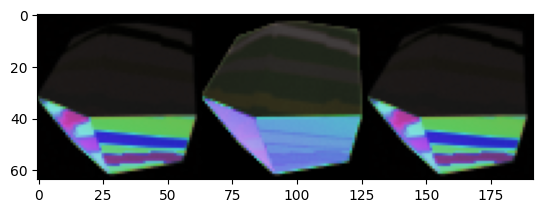

In [84]:
print(len(list(train_dataset)))
def PhotoNormalMask(imtoshownum):
    answers = mass_hsl_rgb(np.array([
        all_photos[imtoshownum], 
        normalizeNegativeImage(answerList[imtoshownum], all_masks[imtoshownum]),
        all_albedos[imtoshownum] + answerList[imtoshownum]
    ]))
    imtoshow = np.concatenate( answers, axis=1).astype("float32")
    plt.imshow(imtoshow)
print(all_vectors[2003])
PhotoNormalMask(2003)

In [90]:
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    vector_input = keras.layers.Input(shape=(3,), name='vector_input')
    y = keras.layers.Dense(256, activation='relu')(vector_input)
    
    # Объединение выходов
    combined = keras.layers.concatenate([x, y])
    
    # Полносвязный слой
    z = keras.layers.Dense(4*16*16, activation='tanh')(combined)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(8*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    

    resh = keras.layers.Reshape((16, 16, 4))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    output = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='tanh')(anticonv1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input, vector_input], outputs=output)
    return model

In [91]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.01)

In [93]:
model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 4)    112         ['image_input[0][0]']            
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 32, 32, 4)   0           ['conv2d_16[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 32, 32, 7)    259         ['max_pooling2d_16[0][0]'] 

In [100]:
model.fit(train_dataset, epochs=50)

Epoch 1/50
106/106 [==============================] - 2s 19ms/step - loss: 0.0178
Epoch 2/50
106/106 [==============================] - 2s 20ms/step - loss: 0.0178
Epoch 3/50
106/106 [==============================] - 2s 20ms/step - loss: 0.0178
Epoch 4/50
106/106 [==============================] - 2s 19ms/step - loss: 0.0179
Epoch 5/50
106/106 [==============================] - 2s 19ms/step - loss: 0.0179
Epoch 6/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0179
Epoch 7/50
106/106 [==============================] - 2s 19ms/step - loss: 0.0177
Epoch 8/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0177
Epoch 9/50
106/106 [==============================] - 2s 19ms/step - loss: 0.0178
Epoch 10/50
106/106 [==============================] - 2s 20ms/step - loss: 0.0179
Epoch 11/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0180
Epoch 12/50
106/106 [==============================] - 2s 18ms/step - loss: 0.0180
Epoch 13/50
1

1/1 [==============================] - 0s 21ms/step
(640, 768, 3)
Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  


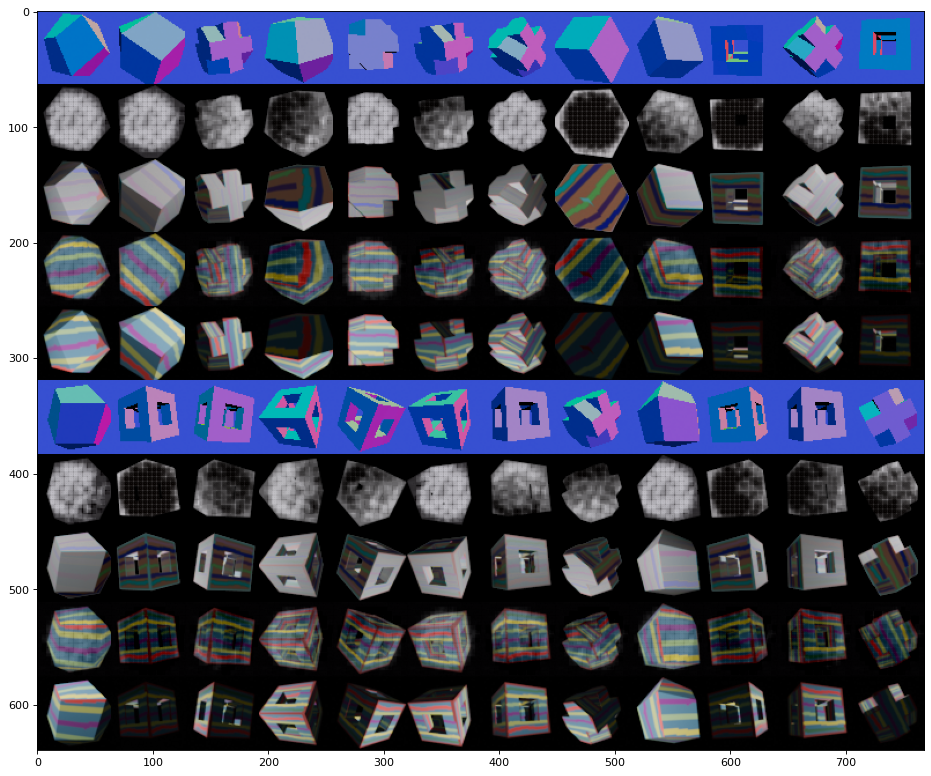

In [102]:
toinset = np.array([i * 100 for i in range(12)])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([i * 100 + 50 for i in range(12)])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
print(bigpicture.shape)
plt.figure(figsize=(16, 12), dpi=80)
print("Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  ")
plt.imshow(bigpicture.astype("float32"))

In [112]:
#model.evaluate(test_dataset) Эвалуация потом

In [66]:
my_thing = all_normals[5]
my_result = model.predict([my_thing.reshape((1,64,64,3)), np.zeros((1,3)) + 1])

1/1 [==============================] - 0s 21ms/step


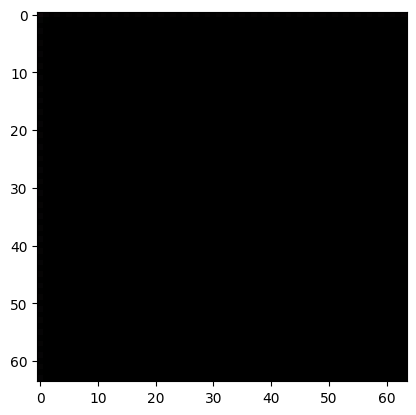

In [67]:
plt.imshow(my_result[0].astype(np.float32))

Визуальная проверка

1/1 [==============================] - 0s 218ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16125249862670898..1.0].


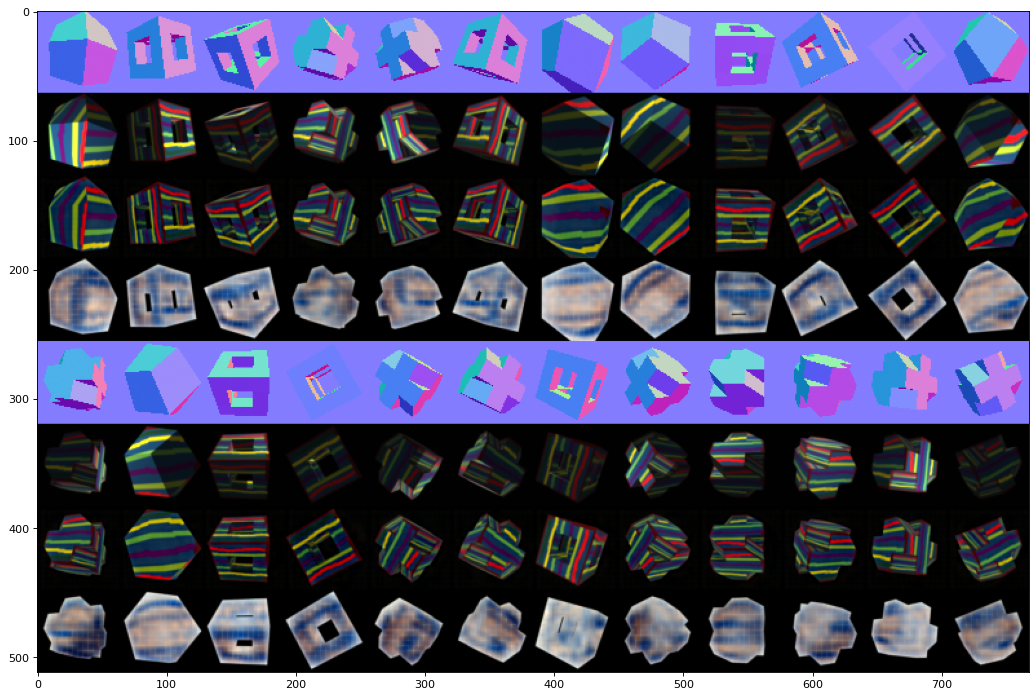

In [45]:
test_predictions = model.predict([test_normals_visual, test_vectorss_visual])
test_preds_norm = []
for i in range(24):
    to_app = normalizeNegativeImage(test_predictions[i], test_masks_visual[i])
    test_preds_norm.append(to_app)
test_preds_norm = np.array(test_preds_norm)

r0 =  np.concatenate(test_photos_visual[0:12], axis=1)
r1 =  np.concatenate(test_normals_visual[0:12], axis=1)
r2 =  np.concatenate(test_albedos_visual[0:12] + test_predictions[0:12], axis=1)
n1 =  np.concatenate(test_preds_norm[0:12], axis=1)
r3 =  np.concatenate(test_photos_visual[12:24], axis=1)
r4 =  np.concatenate(test_normals_visual[12:24], axis=1)
r5 =  np.concatenate(test_albedos_visual[12:24] +test_predictions[12:24], axis=1)
n2 =  np.concatenate(test_preds_norm[12:24], axis=1)

finalimage = np.concatenate([r1, r0, r2, n1, r4, r3, r5, n2], axis=0)
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(finalimage)

Вращение источника света

In [40]:
chosenID = 8

myVector = test_vectorss_visual[chosenID]
# this piece is modified to change x and z, not x and y
vector_list = np.zeros((24, 3))
for i in range(24):
    vector_to_add = myVector
    new_x, new_y = rotate_vector((vector_to_add[0], vector_to_add[2]), 15 * i)
    vector_list[i][0] = new_x
    vector_list[i][1] = vector_to_add[1]
    vector_list[i][2] = new_y
myNormals = np.repeat(test_normals_visual[chosenID][np.newaxis, ...], 24, axis=0)
print(vector_list[1:12:3])

NameError: name 'test_vectorss_visual' is not defined

In [41]:
relit_albedos = model.predict([myNormals, vector_list])
relit_albedos2 = []
for i in range(24):
    relit_albedos2.append( normalizeNegativeImage(relit_albedos[i], test_masks_visual[chosenID]) )
    relit_albedos[i] = (test_albedos_visual[chosenID] + relit_albedos[i]) * test_masks_visual[chosenID] 
final_image = np.concatenate([
    np.concatenate(relit_albedos[0:6], axis = 1),
    np.concatenate(relit_albedos[6:12], axis = 1),
    np.concatenate(relit_albedos[12:18], axis = 1),
    np.concatenate(relit_albedos[18:24], axis = 1)   ,
    np.concatenate(relit_albedos2[0:6], axis = 1),
    np.concatenate(relit_albedos2[6:12], axis = 1),
    np.concatenate(relit_albedos2[12:18], axis = 1),
    np.concatenate(relit_albedos2[18:24], axis = 1)   
    ], axis = 0 )
plt.figure(figsize=(12, 16), dpi=80)
plt.imshow(np.clip(final_image, 0, 1))

NameError: name 'myNormals' is not defined

In [199]:
#model.save("goodNTLmodel001.keras")
# Попытка 1, 300 эпох. 
# Вроде бы работает очень хорошо, но требует маски для того чтобы не освещать лишнее
# Иногда она вообще не совпадает со входным изображением

In [46]:
#model.save("overfitgoodrubic.keras")
# Попытка 2, 1500 эпох. Добавил +2 глубоких слоя.
# Выход модели приобрел форму светового шарика освещения, вроде бы это круто
# Иногда она вообще не совпадает со входным изображением

Это нужно пустить прежде чем запускать тестовые кусочки кода

In [197]:
# Сохранение в виде гифки
import numpy as np
from PIL import Image

images_array = (np.clip(relit_albedos, 0, 1) * 255).astype(np.uint8)
images = []
for img in images_array:
    images.append(Image.fromarray(img).resize((128, 128)))

images[0].save('animation.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,  # Длительность каждого кадра в миллисекундах
               loop=0)  # 0 - бесконечный цикл

In [43]:
locloc2 = "BigDataCubes\CombinedDatasets" 
namename2 = "\Part0"
all_test_photos = np.load(locloc2 + namename2 + 'Photos.npy')
test_photos_visual = all_test_photos[1000:1024]
del all_test_photos;
all_test_normals = np.load(locloc2 + namename2 + 'Normals.npy')
test_normals_visual = all_test_normals[1000:1024]
del all_test_normals;
all_test_vectors = np.load(locloc2 + namename2 + 'Vectors.npy')
test_vectorss_visual = all_test_vectors[1000:1024]
del all_test_vectors;
all_test_albedos = np.load(locloc2 + namename2 + 'Albedos.npy')
test_albedos_visual = all_test_albedos[1000:1024]
del all_test_albedos;
all_test_masks = np.load(locloc2 + namename2 + 'Masks.npy')
test_masks_visual = all_test_masks[1000:1024]
del all_test_masks;

In [44]:
def rotate_vector(my_vector, degrees):
    x, y = my_vector
    pies = math.radians(degrees)
    new_x = x * math.cos(pies) - y * math.sin(pies)
    new_y = x * math.sin(pies) + y * math.cos(pies)
    return (round(new_x, 2),round(new_y, 2))

In [49]:
""" # Старое и не нужное, еще и слишком сложное
imgoutput = model.predict(all_test_normals)
every_24th_image = imgoutput[::24]

dumblist = list(test_dataset)
dumb_albedos = np.empty((0,64,64,3))
for i in range(len(dumblist)):
    dumb_albedos = np.concatenate([dumb_albedos, dumblist[i][0][0]], axis=0)
dumb_answers = np.empty((0,64,64,3))
for i in range(len(dumblist)):
    dumb_answers = np.concatenate([dumb_answers, dumblist[i][1]], axis=0)
combined_image_fake = np.zeros((192, 192, 3))
combined_image_true = np.zeros((192, 192, 3))
raw_fake = np.zeros((192, 192, 3))
raw_true = np.zeros((192, 192, 3))
for i in range(3):  
    for j in range(3):  
        index = i * 4 + j
        raw_fake[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] =  (
            (every_24th_image[index] - every_24th_image[index].min()) / every_24th_image[index].ptp()
        )
        
        raw_true[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = (
            (dumb_answers[index * 24] - dumb_answers[index * 24].min()) / dumb_answers[index * 24].ptp()
        )

        combined_image_fake[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = dumb_albedos[index * 24] + every_24th_image[index]
        combined_image_true[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = dumb_albedos[index * 24] + dumb_answers[index*24]

print(combined_image_fake.max(), combined_image_fake.min())
combined_image_fake = np.clip(combined_image_fake, 0 ,1 )
combined_image_true = np.clip(combined_image_true, 0 ,1 )
combined_image_image = np.concatenate([combined_image_fake, combined_image_true], axis=1)
combined_raw_image = np.concatenate([raw_fake, raw_true], axis=1)
combined_super_image = np.concatenate([combined_image_image, combined_raw_image], axis=0)
plt.figure(figsize=(14, 14), dpi=80)
plt.imshow(combined_super_image) 
"""

' # Старое и не нужное, еще и слишком сложное\nimgoutput = model.predict(all_test_normals)\nevery_24th_image = imgoutput[::24]\n\ndumblist = list(test_dataset)\ndumb_albedos = np.empty((0,64,64,3))\nfor i in range(len(dumblist)):\n    dumb_albedos = np.concatenate([dumb_albedos, dumblist[i][0][0]], axis=0)\ndumb_answers = np.empty((0,64,64,3))\nfor i in range(len(dumblist)):\n    dumb_answers = np.concatenate([dumb_answers, dumblist[i][1]], axis=0)\ncombined_image_fake = np.zeros((192, 192, 3))\ncombined_image_true = np.zeros((192, 192, 3))\nraw_fake = np.zeros((192, 192, 3))\nraw_true = np.zeros((192, 192, 3))\nfor i in range(3):  \n    for j in range(3):  \n        index = i * 4 + j\n        raw_fake[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] =  (\n            (every_24th_image[index] - every_24th_image[index].min()) / every_24th_image[index].ptp()\n        )\n        \n        raw_true[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = (\n            (dumb_answers[index * 24] - dumb_answers